# 语音唤醒（用Spectrogram信号）

思路：提取spectrogram属性，使用用1D CNN+RNN进行学习。

数据集是mini_speech_commands，目标command是['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

In [1]:
import pandas as pd

import os
import pathlib
import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import librosa

import sklearn as sk
import scipy

## Import the Speech Commands dataset

第1步：将所有的wav文件组成list

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
fileset = [file for file in glob.glob(str(data_dir) + "**/**/*.wav", recursive=True)]

In [3]:
len(fileset)

8000

第2步：list导入到DataFrame

In [4]:
dataset = pd.DataFrame(fileset, columns=['path'])

第3步：将文件夹的名称提取作为指令

In [5]:
dataset['command'] = dataset['path'].apply(lambda x : os.path.basename(os.path.dirname(x)))

In [6]:
dataset.head()

,path,command
0,data\mini_speech_commands\down\004ae714_nohash...,down
1,data\mini_speech_commands\down\00b01445_nohash...,down
2,data\mini_speech_commands\down\00f0204f_nohash...,down
3,data\mini_speech_commands\down\0132a06d_nohash...,down
4,data\mini_speech_commands\down\0132a06d_nohash...,down


第4步：提取spectrum并写入dataframe

In [7]:
# 计算时频谱

def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate /1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [8]:
# 查看scipy.io读取的数据和librosa的区别
from scipy.io import wavfile
import scipy.io

sample_rate, signal= scipy.io.wavfile.read(dataset.loc[0,'path'])
print(signal)
print(signal.shape, signal.dtype)
s, sr = librosa.load(dataset.loc[0,'path'], sr=16000)
print(s)
print(s.shape,s.dtype)

[-130 -135 -131 ... -154 -190 -224]
(16000,) int16
[-0.00396729 -0.00411987 -0.0039978  ... -0.00469971 -0.00579834
 -0.00683594]
(16000,) float32


In [9]:
# 输入文件的路径返回MFCC

def get_specgram(file_path):
    sample_rate, signal= scipy.io.wavfile.read(file_path)
    # 统一输入音频文件长度，当音频文件大于1秒时切尾，当音频长度小于1秒时补零
    signal_padding = np.zeros((16000,))
    if len(signal) >= 16000:
        signal_padding = signal[:16000]
    else:        
        signal_padding[:len(signal)] = signal
    # 获取频谱
    _, _, specgram = log_specgram(signal_padding, sample_rate=sample_rate)

    return specgram

In [10]:
# 测试
file_path_check = dataset.loc[0,'path']
file_path_check 

'data\\mini_speech_commands\\down\\004ae714_nohash_0.wav'

In [11]:
spec_check = get_specgram(file_path_check)

In [12]:
spec_check.shape

(99, 161)

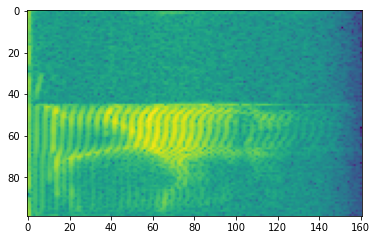

In [13]:
plt.imshow(spec_check)

In [14]:
# 获取每个文件的spectrogram
dataset['spec'] = dataset['path'].apply(lambda x : get_specgram(x))

In [15]:
dataset.head()

,path,command,spec
0,data\mini_speech_commands\down\004ae714_nohash...,down,"[[6.1564674, 5.6721416, 1.4785006, 1.0322386, ..."
1,data\mini_speech_commands\down\00b01445_nohash...,down,"[[-8.119339, -7.100962, -2.9746146, -1.9071885..."
2,data\mini_speech_commands\down\00f0204f_nohash...,down,"[[3.2663877, 6.1833525, 5.1544065, 5.402227, 5..."
3,data\mini_speech_commands\down\0132a06d_nohash...,down,"[[-7.466669, -9.616711, -4.86994, -3.218716, -..."
4,data\mini_speech_commands\down\0132a06d_nohash...,down,"[[-5.385032, -4.7529283, -4.9070916, -4.096608..."


In [16]:
# 用sklearn.preprocessing.LabelEncoder将指令转换为数字
le = sk.preprocessing.LabelEncoder()
dataset['cmd_value'] = le.fit_transform(dataset['command'])

In [17]:
dataset.tail()

,path,command,spec,cmd_value
7995,data\mini_speech_commands\yes\fe1916ba_nohash_...,yes,"[[-10.874792, -5.53589, -3.86621, -4.4400816, ...",7
7996,data\mini_speech_commands\yes\fe5c4a7a_nohash_...,yes,"[[7.4970326, 8.869189, 7.062622, 7.239739, 10....",7
7997,data\mini_speech_commands\yes\ff21fb59_nohash_...,yes,"[[1.7132064, 5.4771934, 5.961012, 3.4359176, 1...",7
7998,data\mini_speech_commands\yes\ffd2ba2f_nohash_...,yes,"[[0.16514386, 2.859499, 6.4408054, 7.1973853, ...",7
7999,data\mini_speech_commands\yes\ffd2ba2f_nohash_...,yes,"[[-5.4296527, -3.146472, -1.6233717, -2.900053...",7


## Build and train the model

In [18]:
# 命令类别
le.classes_

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype=object)

In [19]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
input_dim = (99, 161)
output_dim = len(le.classes_)
dropout = 0.2

input_data = Input(shape=input_dim)
x = Conv1D(filters=256, kernel_size=10, strides=4)(input_data)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)

x = LSTM(128, activation='relu', return_sequences=True, dropout=dropout)(x)
x = LSTM(128, activation='relu', return_sequences=False, dropout=dropout)(x)

x = Dense(units=64, activation='relu')(x)
x = Dropout(dropout)(x)

output_data = Dense(output_dim, activation='softmax')(x)

K.clear_session
model = Model(inputs=input_data, outputs=output_data)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 161)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 256)           412416    
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 23, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 23, 128)           197120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)              

In [21]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard

sgd = SGD(lr=0.00001, clipnorm=1.0)
adam = Adam(lr=1e-4, clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy'],
)

In [22]:
X = np.array([i for i in dataset['spec']])

In [23]:
X.shape

(8000, 99, 161)

In [24]:
y = np.array(dataset['cmd_value'])

In [25]:
y.shape

(8000,)

In [26]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
EPOCHS = 50
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir='logs', histogram_freq=1, update_freq='epoch'), 
               EarlyStopping(verbose=1, patience=5), 
               ModelCheckpoint('best_model_part1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')],
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/50
  1/100 [..............................] - ETA: 0s - loss: 2.1225 - accuracy: 0.1719WARNING:tensorflow:From C:\Users\002706\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 1.8759 - accuracy: 0.2900
Epoch 00001: val_accuracy improved from -inf to 0.39375, saving model to best_model.hdf5
100/100 [==============================] - 39s 388ms/step - loss: 1.8759 - accuracy: 0.2900 - val_loss: 1.7331 - val_accuracy: 0.3938
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.4922 - accuracy: 0.4573
Epoch 00002: val_accuracy improved from 0.39375 to 0.50563, saving model to best_model.hdf5
100/100 [==============================] - 40s 398ms/step - loss: 1.4922 - accuracy: 0.4573 - val_loss: 1.3738 - val_a

Epoch 26/50
100/100 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.9220
Epoch 00026: val_accuracy did not improve from 0.92188
100/100 [==============================] - 39s 392ms/step - loss: 0.2456 - accuracy: 0.9220 - val_loss: 0.3028 - val_accuracy: 0.9081
Epoch 27/50
100/100 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9197
Epoch 00027: val_accuracy did not improve from 0.92188
100/100 [==============================] - 38s 382ms/step - loss: 0.2423 - accuracy: 0.9197 - val_loss: 0.3225 - val_accuracy: 0.9175
Epoch 28/50
100/100 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9250
Epoch 00028: val_accuracy did not improve from 0.92188
100/100 [==============================] - 40s 400ms/step - loss: 0.2263 - accuracy: 0.9250 - val_loss: 0.3235 - val_accuracy: 0.9100
Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9236
Epoch 00029: val_accuracy did not improve fro

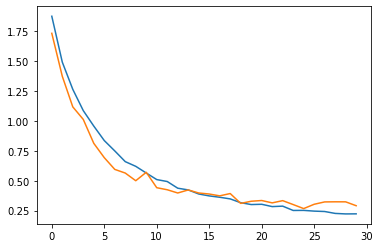

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.show()

In [29]:
# 保存模型
# model.save('models/voice_trigger_model.h5')

## Evaluate test set performance
用麦克录制语音输入，通过模型进行预测结果，详见另外一个notebook《voice_trigger_test_mic.ipynb》